# Stochastics Methods for Reservoir Modeling
## Group 5

* Xin Liu
* Buddy Price
* Jose Salazar

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
sns.set()
sns.set_style('white')

### Tabular Data Structures

In [2]:
os.chdir('C:\\Users\\jjs4476\\Documents\\Stochastic Methods for Reservoir Modeling\\Assignments') # Modify the directory

In [3]:
df = pd.read_csv('5_sample_data.csv') # Be sure to have 5_sample_data in your files
df.head(10) # A quick view of the data just loaded

,Unnamed: 0,X,Y,Facies,Porosity,Perm,AI
0,1,70.0,860.0,1.0,0.118640,3.117596,7035.590426
1,3,70.0,720.0,1.0,0.120775,1.755401,6327.155846
2,5,70.0,580.0,1.0,0.152136,90.385506,5547.976415
3,6,70.0,510.0,1.0,0.148497,81.199756,4025.534147
4,8,70.0,370.0,1.0,0.158123,1497.094898,4385.428975
5,9,70.0,300.0,1.0,0.132016,6292.156474,4912.077977
6,10,70.0,230.0,1.0,0.145744,3713.824769,5151.593694
7,11,70.0,160.0,1.0,0.168037,537.660203,5440.911268
8,12,70.0,90.0,1.0,0.128605,27.417819,5929.812808
9,15,140.0,860.0,1.0,0.093445,7.373822,6439.805211


In [4]:
df.info()  # more info about the data

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 292 entries, 0 to 291
Data columns (total 7 columns):
Unnamed: 0    292 non-null int64
X             292 non-null float64
Y             292 non-null float64
Facies        292 non-null float64
Porosity      292 non-null float64
Perm          292 non-null float64
AI            292 non-null float64
dtypes: float64(6), int64(1)
memory usage: 16.0 KB


In [5]:
df = df.rename(columns={'Unnamed: 0': 'Sample_n'}) # Rename one column
df.describe().round(2) # Overall statistics

,Sample_n,X,Y,Facies,Porosity,Perm,AI
count,292.00,292.00,292.00,292.00,292.00,292.00,292.00
mean,281.90,449.33,525.86,0.76,0.12,1037.00,6221.13
std,171.08,278.05,272.45,0.43,0.03,3554.70,1321.14
min,1.00,0.00,19.00,0.00,0.04,0.01,3492.04
25%,125.00,210.00,300.00,1.00,0.10,1.30,5197.95
50%,277.50,420.00,519.00,1.00,0.12,11.45,6145.97
75%,429.25,670.00,790.00,1.00,0.14,201.22,7199.16
max,587.00,990.00,999.00,1.00,0.21,26466.74,9197.48


In [6]:
df[df['Facies'] == 1].describe().round(2) # Statistics only for the sand facies

,Sample_n,X,Y,Facies,Porosity,Perm,AI
count,222.00,222.00,222.00,222.0,222.00,222.00,222.00
mean,273.02,356.28,558.58,1.0,0.13,1362.43,5736.94
std,174.02,230.50,239.66,0.0,0.02,4024.23,1055.79
min,1.00,0.00,20.00,1.0,0.07,0.01,3492.04
25%,94.25,190.00,359.00,1.0,0.11,2.49,4901.30
50%,275.00,350.00,559.00,1.0,0.13,22.01,5690.53
75%,416.75,490.00,790.00,1.0,0.14,490.75,6480.77
max,587.00,960.00,999.00,1.0,0.21,26466.74,8283.59


In [7]:
df[df['Facies'] == 0].describe().round(2) # Statistics only for the shale facies

,Sample_n,X,Y,Facies,Porosity,Perm,AI
count,70.00,70.00,70.00,70.0,70.00,70.00,70.00
mean,310.07,744.43,422.10,0.0,0.09,4.93,7756.71
std,159.32,199.19,338.71,0.0,0.02,7.00,802.75
min,82.00,50.00,19.00,0.0,0.04,0.07,5918.93
25%,167.50,622.50,126.50,0.0,0.08,0.50,7196.26
50%,291.50,770.00,334.00,0.0,0.09,1.48,7734.10
75%,446.50,910.00,719.75,0.0,0.10,6.76,8255.13
max,579.00,990.00,999.00,0.0,0.14,32.99,9197.48


### Regular Gridded Data Structures

In [8]:
# utility to convert 1D or 2D numpy ndarray to a GSLIB Geo-EAS file for use with GSLIB methods   
def ndarray2GSLIB(array,data_file,col_name):
    file_out = open(data_file, "w")
    file_out.write(data_file + '\n')  
    file_out.write('1 \n')  
    file_out.write(col_name  + '\n') 
    if array.ndim == 2:
        ny = (array.shape[0])
        nx = (array.shape[1])
        ncol = 1
        for iy in range(0, ny):
            for ix in range(0, nx):
                file_out.write(str(array[ny-1-iy,ix])+ '\n')        
    elif array.ndim == 1:
        nx = len(array)        
        for ix in range(0, nx):
            file_out.write(str(array[ix])+ '\n')             
    else:       
        Print("Error: must use a 2D array")            
        file_out.close()
        return            
    file_out.close()

# utility to convert GSLIB Geo-EAS files to a 1D or 2D numpy ndarray for use with Python methods
def GSLIB2ndarray(data_file,kcol,nx,ny): 
    colArray = []
    if ny > 1:
        array = np.ndarray(shape=(ny,nx),dtype=float,order='F')
    else:
        array = np.zeros(nx)    
    with open(data_file) as myfile:   # read first two lines
        head = [next(myfile) for x in range(2)]
        line2 = head[1].split()
        ncol = int(line2[0])          # get the number of columns
        for icol in range(0, ncol):   # read over the column names
            head = [next(myfile) for x in range(1)]
            if icol == kcol:
                col_name = head[0].split()[0]       
        if ny > 1:
            for iy in range(0,ny):
                for ix in range(0,nx):
                    head = [next(myfile) for x in range(1)]
                    array[ny-1-iy][ix] = head[0].split()[kcol]
        else:
            for ix in range(0,nx):
                head = [next(myfile) for x in range(1)]
                array[ix] = head[0].split()[kcol]
    return array,col_name
    
# pixel plot, reimplemention in Python of GSLIB pixelplt with MatPlotLib methods (commented out image file creation)
def pixelplt(array,xmin,xmax,ymin,ymax,step,vmin,vmax,title,xlabel,ylabel,vlabel,cmap,fig_name):
    xx, yy = np.meshgrid(np.arange(xmin, xmax, step),np.arange(ymax, ymin, -1*step))
    plt.figure(figsize=(8,6))
    im = plt.contourf(xx,yy,array,cmap=cmap,vmin=vmin,vmax=vmax,levels=np.linspace(vmin,vmax,100))
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    cbar = plt.colorbar(im,orientation = 'vertical',ticks=np.linspace(vmin,vmax,10))
    cbar.set_label(vlabel, rotation=270, labelpad=20)
#    plt.savefig(fig_name + '.' + image_type,dpi=dpi)
    plt.show()
    return im

In [9]:
AI_map = pd.read_csv('5_AI.csv', header=None)   # Read the AI 2D grid as a DataFrame. There is no header
AI_map = AI_map.values  # Get only the np values

**Visualization**

**Summary statistics**

In [10]:
xmin = 0.0 
xmax = 1000.0
ymin = 0.0
ymax = 1000.0
cell_size = 10.0
gcsize = 10.0                 # grid cell size
vmin = np.ceil(AI_map.min())
vmax = np.ceil(AI_map.max())
cmap = plt.cm.plasma

In [11]:
stats = stats.describe(AI_map.flatten())
stats

DescribeResult(nobs=10000, minmax=(3041.1785908071197, 10003.558948893804), mean=6577.0, variance=1730450.2050205024, skewness=-0.15308727756669102, kurtosis=-0.6100682427084996)

In [12]:
mean_AI = np.mean(AI_map)                                 # array summary statistics
stdev_AI = np.std(AI_map)
min_AI = np.min(AI_map)
max_AI = np.max(AI_map)
P10_AI ,P90_AI = np.percentile(AI_map,[0.10,0.90])
print('Summary Statistics of AI \n Mean = ' + str(mean_AI) + ', StDev = ' + str(stdev_AI))
print(' Min = ' + str(min_AI) + ', Max = ' + str(max_AI))
print(' P10 = ' + str(P10_AI) + ', P90 = ' + str(P90_AI))

Summary Statistics of AI 
 Mean = 6577.0, StDev = 1315.3999999999999
 Min = 3041.1785908071197, Max = 10003.558948893804
 P10 = 3261.3782722038095, P90 = 3722.6077429307097


### GeostatsPy: Basic Univariate Statistics and Distribution Plotting for Subsurface Data Analytics in Python

In [13]:
import geostatspy.GSLIB as GSLIB           # GSLIB utilies, visualization and wrapper
import geostatspy.geostats as geostats     # GSLIB methods convert to Python

In [14]:
print('The minimum is ' + str(round(np.amin(df['Porosity'].values),2)))
print('The maximum is ' + str(round(np.amax(df['Porosity'].values),2)))
print('The range (maximum - minimum) is ' + str(round(np.ptp(df['Porosity'].values),2)))
print('The P10 is ' + str(round(np.percentile(df['Porosity'].values,10),3)))
print('The P50 is ' + str(round(np.percentile(df['Porosity'].values,50),3)))
print('The P90 is ' + str(round(np.percentile(df['Porosity'].values,90),3)))
print('The P13 is ' + str(round(np.percentile(df['Porosity'].values,13),3)))
print('The media (P50) is ' + str(round(np.median(df['Porosity'].values),3)))
print('The mean is ' + str(round(np.mean(df['Porosity'].values),3)))

The minimum is 0.04
The maximum is 0.21
The range (maximum - minimum) is 0.17
The P10 is 0.083
The P50 is 0.116
The P90 is 0.158
The P13 is 0.087
The media (P50) is 0.116
The mean is 0.119


**Plotting distributions**

In [15]:
GSLIB.hist

<function geostatspy.GSLIB.hist(array, xmin, xmax, log, cumul, bins, weights, xlabel, title, fig_name)>

Let's visualize the histogram of porosity.

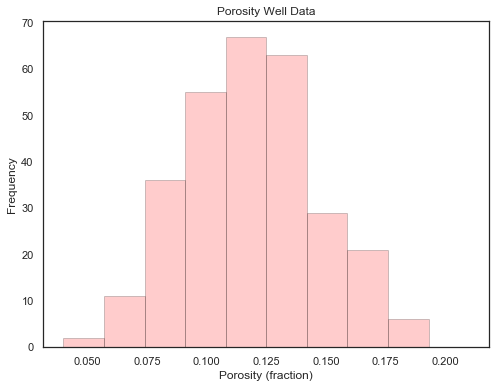

In [16]:
pormin = 0.04
pormax = 0.21
GSLIB.hist(df['Porosity'].values, pormin, pormax, log=False, cumul = False, bins=10,
           weights = None, xlabel='Porosity (fraction)', title='Porosity Well Data', fig_name='hist_Porosity')

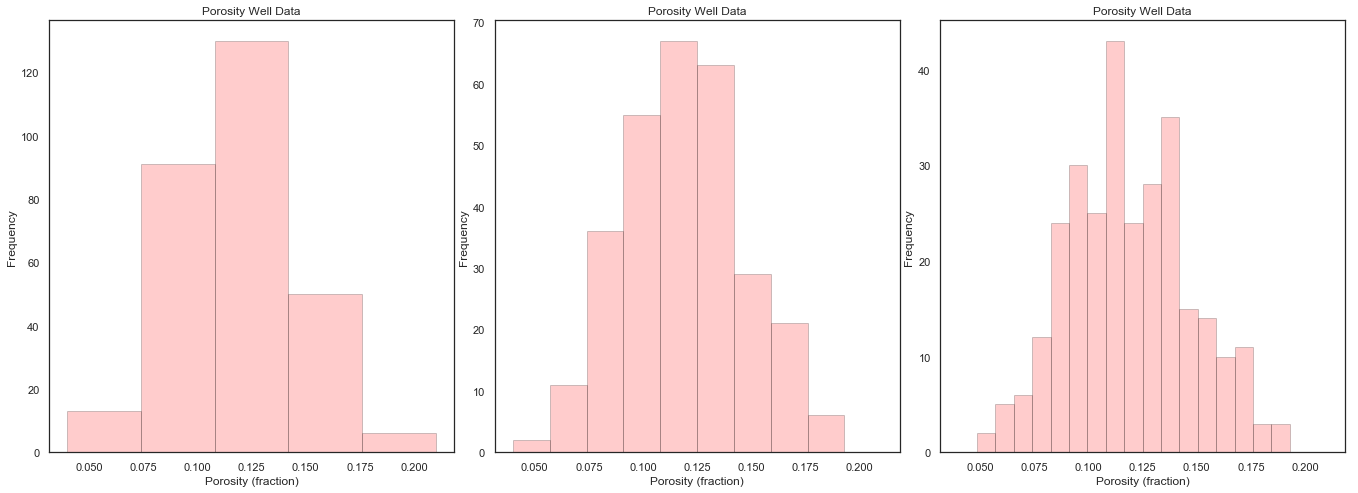

In [17]:
plt.subplot(131)
GSLIB.hist_st(df['Porosity'].values,pormin,pormax,log=False,cumul = False,bins=5,weights = None,xlabel='Porosity (fraction)',title='Porosity Well Data')

plt.subplot(132)
GSLIB.hist_st(df['Porosity'].values,pormin,pormax,log=False,cumul = False,bins=10,weights = None,xlabel='Porosity (fraction)',title='Porosity Well Data')

plt.subplot(133)
GSLIB.hist_st(df['Porosity'].values,pormin,pormax,log=False,cumul = False,bins=20,weights = None,xlabel='Porosity (fraction)',title='Porosity Well Data')

plt.subplots_adjust(left=0.0, bottom=0.0, right=3.0, top=1.5, wspace=0.1, hspace=0.2)
plt.savefig('hist_Porosity_Multiple_bins.tif',dpi=600,bbox_inches="tight")
plt.show()

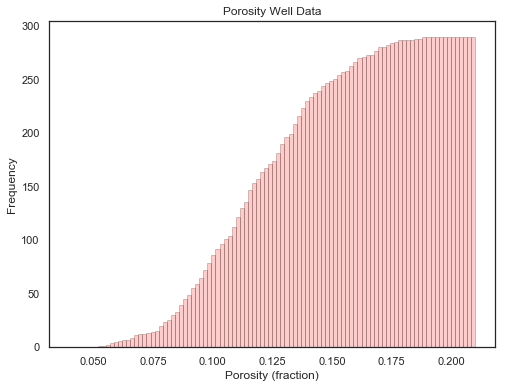

In [18]:
GSLIB.hist(df['Porosity'].values, pormin, pormax, log=False, cumul = True,
           bins=100, weights = None, xlabel='Porosity (fraction)',
           title='Porosity Well Data', fig_name='hist_Porosity_CDF')

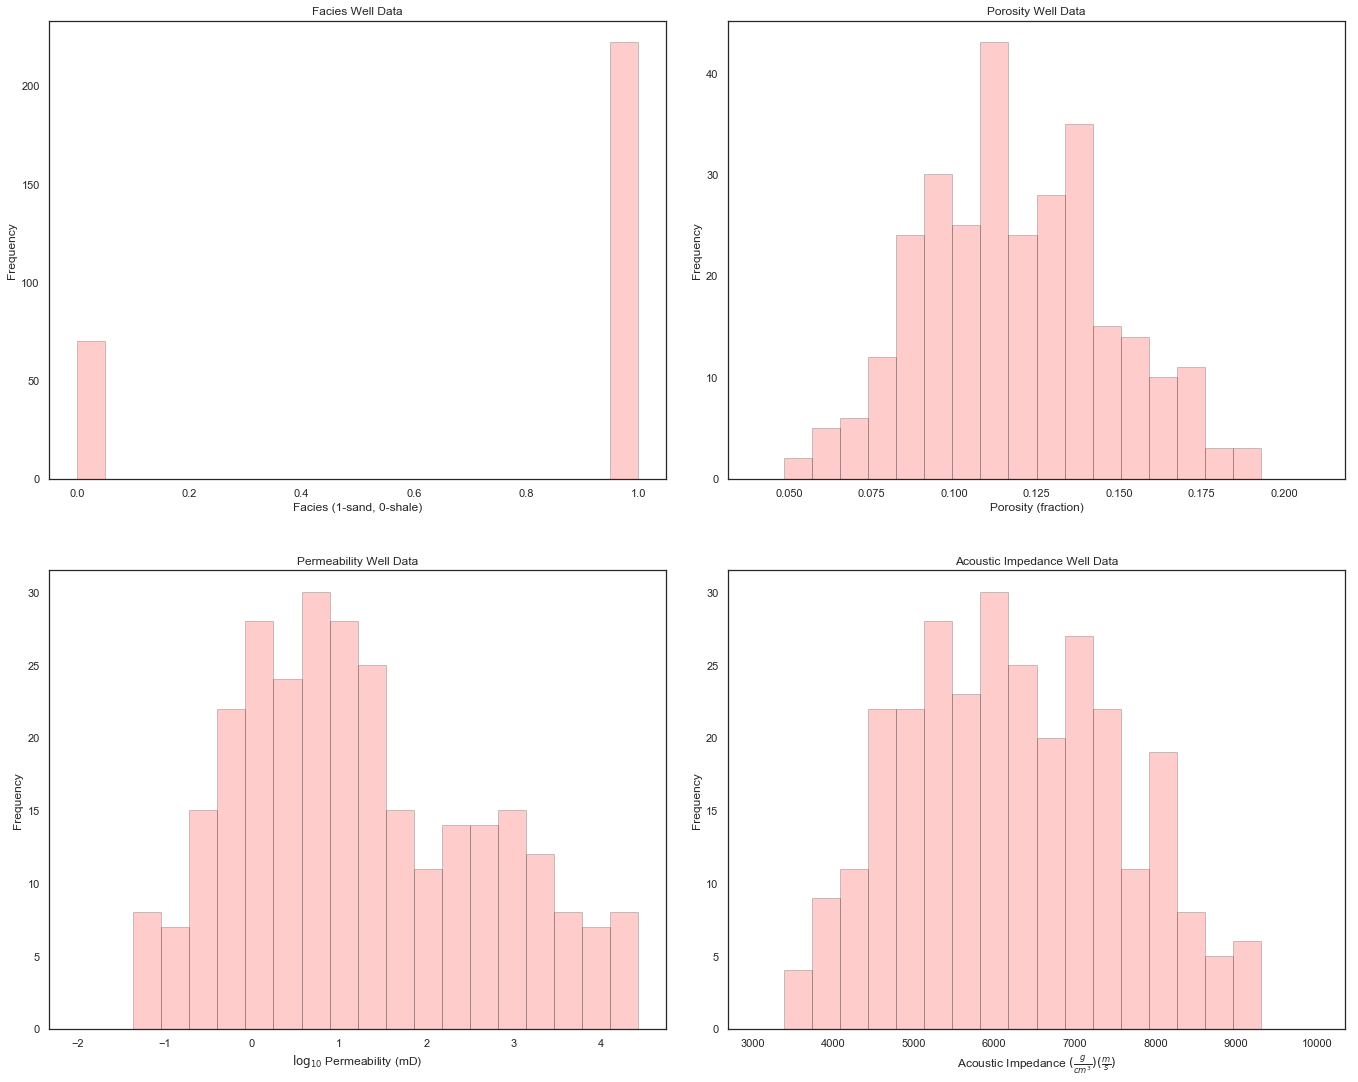

In [19]:
permmin = 0.01
permmax = 26500
AImin = np.ceil(AI_map.min())
AImax = np.ceil(AI_map.max())
Fmin = 0
Fmax = 1

plt.subplot(221)
GSLIB.hist_st(df['Facies'].values,Fmin,Fmax,log=False,cumul = False,bins=20,weights = None,xlabel='Facies (1-sand, 0-shale)',title='Facies Well Data')

plt.subplot(222)
GSLIB.hist_st(df['Porosity'].values,pormin,pormax,log=False,cumul = False,bins=20,weights = None,xlabel='Porosity (fraction)',title='Porosity Well Data')

plt.subplot(223)
GSLIB.hist_st(np.log10(df['Perm'].values),np.log10(permmin), np.log10(permmax),log=False,cumul = False,bins=20,weights = None,
              xlabel='$\log_{10}$ Permeability (mD)',title='Permeability Well Data')

plt.subplot(224)
GSLIB.hist_st(df['AI'].values,AImin,AImax,log=False,cumul = False, bins=20, weights = None,
              xlabel=r'Acoustic Impedance $(\frac{g}{cm^3})(\frac{m}{s})$' ,title='Acoustic Impedance Well Data')

plt.subplots_adjust(left=0.0, bottom=0.0, right=3.0, top=3.5, wspace=0.1, hspace=0.2)
plt.savefig('hist_Porosity_Multiple_bins.tif',dpi=600,bbox_inches="tight")

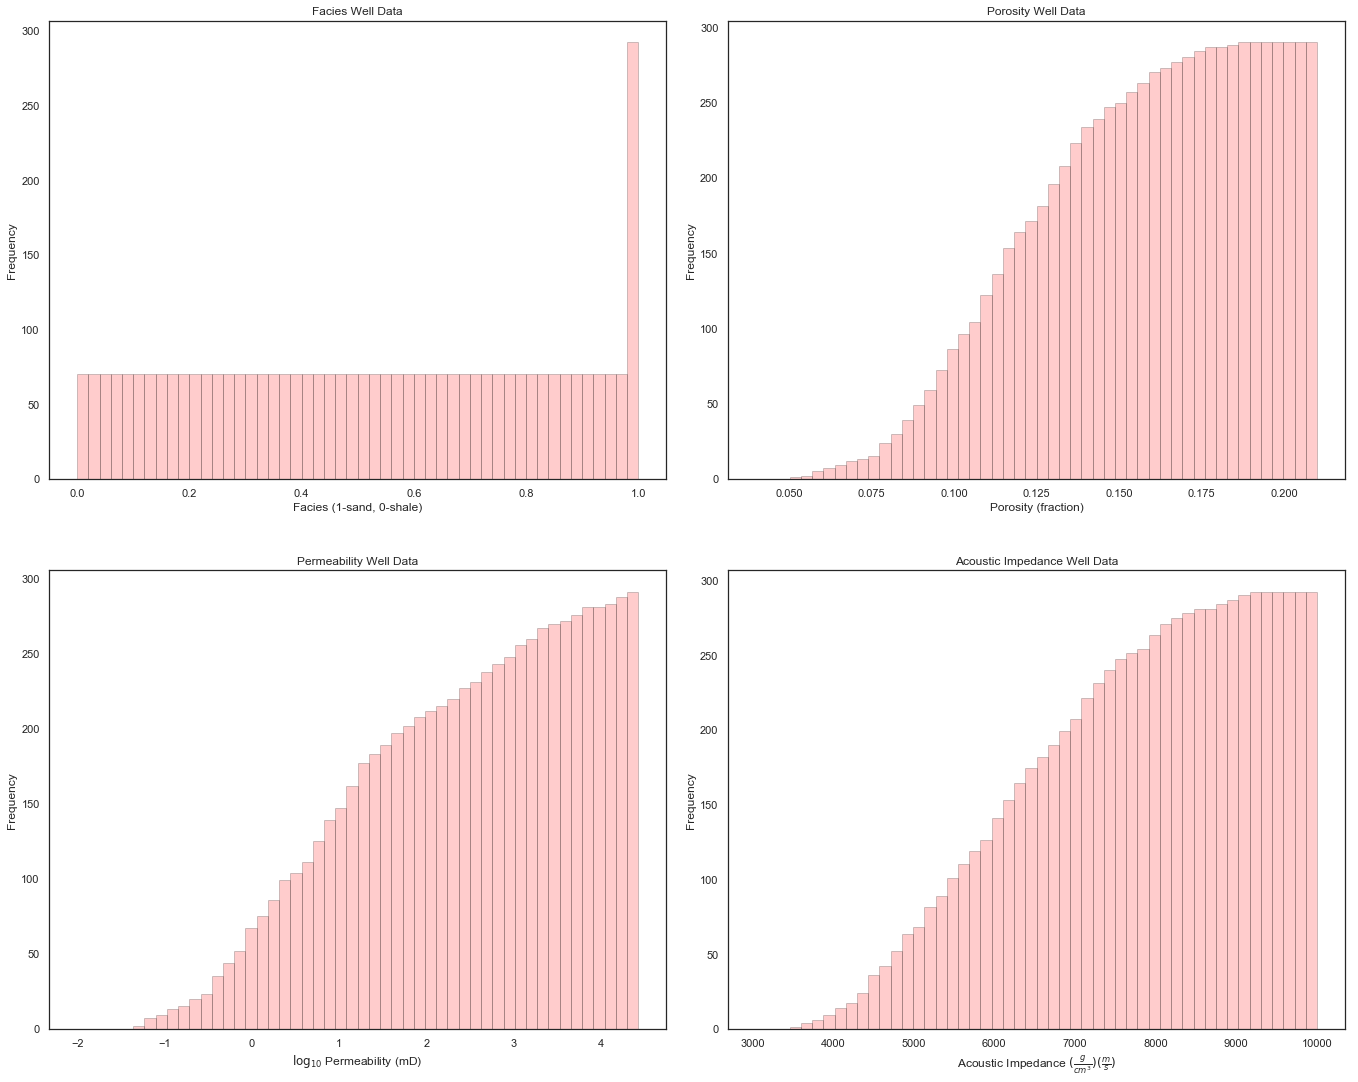

In [20]:
plt.subplot(221)
GSLIB.hist_st(df['Facies'].values,Fmin,Fmax,log=False,cumul = True,bins=50,weights = None,xlabel='Facies (1-sand, 0-shale)',title='Facies Well Data')

plt.subplot(222)
GSLIB.hist_st(df['Porosity'].values,pormin,pormax,log=False,cumul = True,bins=50,weights = None,xlabel='Porosity (fraction)',title='Porosity Well Data')

plt.subplot(223)
GSLIB.hist_st(np.log10(df['Perm'].values),np.log10(permmin),np.log10(permmax),log=False,cumul = True,
              bins=50,weights = None,xlabel='$\log_{10}$ Permeability (mD)',title='Permeability Well Data')

plt.subplot(224)
GSLIB.hist_st(df['AI'].values,AImin,AImax,log=False,cumul = True,bins=50,weights = None,
              xlabel=r'Acoustic Impedance $(\frac{g}{cm^3})(\frac{m}{s})$',title='Acoustic Impedance Well Data')

plt.subplots_adjust(left=0.0, bottom=0.0, right=3.0, top=3.5, wspace=0.1, hspace=0.2)
plt.savefig('hist_Porosity_Multiple_bins.tif',dpi=600,bbox_inches="tight")

### GeostatsPy: Basic Plotting of Subsurface Data

In [21]:
GSLIB.locmap

<function geostatspy.GSLIB.locmap(df, xcol, ycol, vcol, xmin, xmax, ymin, ymax, vmin, vmax, title, xlabel, ylabel, vlabel, cmap, fig_name)>

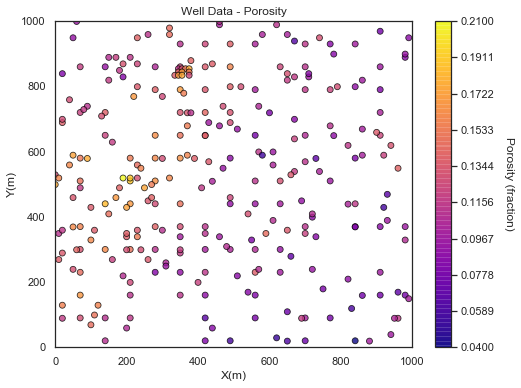

In [22]:
# Sampling location
GSLIB.locmap(df, 'X', 'Y', 'Porosity', xmin, xmax, ymin, ymax, pormin, pormax,
             'Well Data - Porosity', 'X(m)', 'Y(m)', 'Porosity (fraction)', cmap,'locmap_Porosity');

In [23]:
df['log10Perm'] = np.log10(df['Perm']) # Transformation of permeability using logarithm

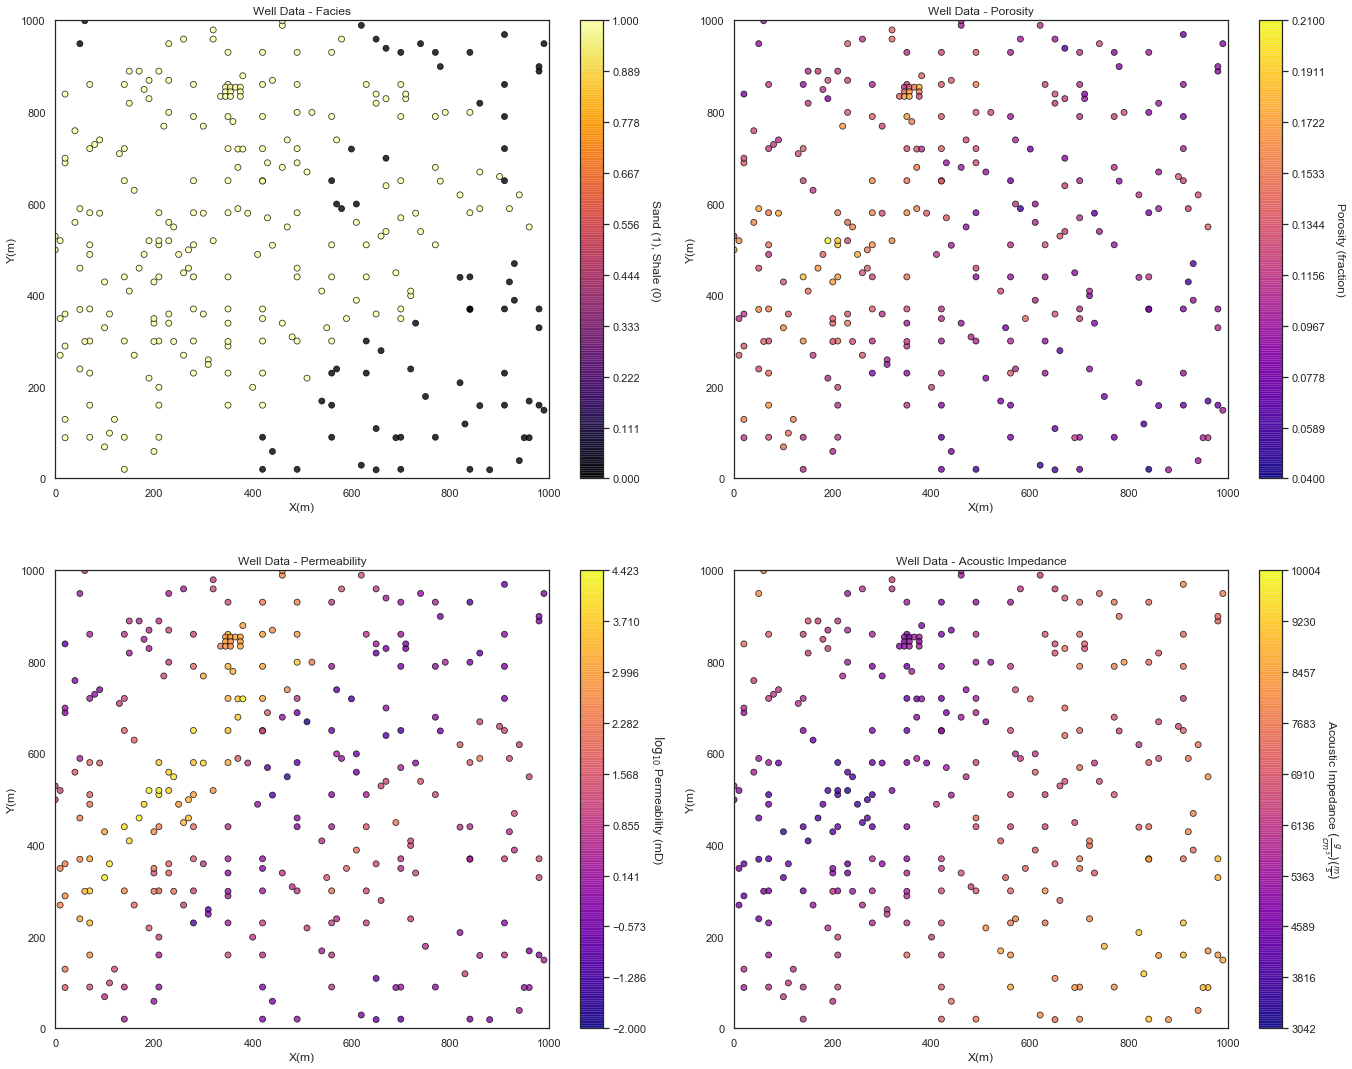

In [24]:
plt.subplot(221)
GSLIB.locmap_st(df,'X','Y', 'Facies', xmin, xmax, ymin, ymax, Fmin, Fmax,
                'Well Data - Facies', 'X(m)', 'Y(m)', 'Sand (1), Shale (0)', plt.cm.inferno)

plt.subplot(222)
GSLIB.locmap_st(df,'X','Y', 'Porosity', xmin, xmax, ymin, ymax, pormin, pormax,
                'Well Data - Porosity', 'X(m)', 'Y(m)', 'Porosity (fraction)', cmap)

plt.subplot(223)
GSLIB.locmap_st(df,'X','Y', 'log10Perm', xmin, xmax, ymin, ymax,np.log10(permmin), np.log10(permmax),
                'Well Data - Permeability', 'X(m)', 'Y(m)', '$\log_{10}$ Permeability (mD)', cmap)

plt.subplot(224)
GSLIB.locmap_st(df,'X','Y', 'AI', xmin, xmax, ymin, ymax, AImin, AImax,
                'Well Data - Acoustic Impedance', 'X(m)', 'Y(m)', r'Acoustic Impedance $(\frac{g}{cm^3})(\frac{m}{s})$',cmap)

plt.subplots_adjust(left=0.0, bottom=0.0, right=3.0, top=3.5, wspace=0.1, hspace=0.2)
plt.savefig('All_location_maps.tif',dpi=600,bbox_inches="tight")

**Seismic data**

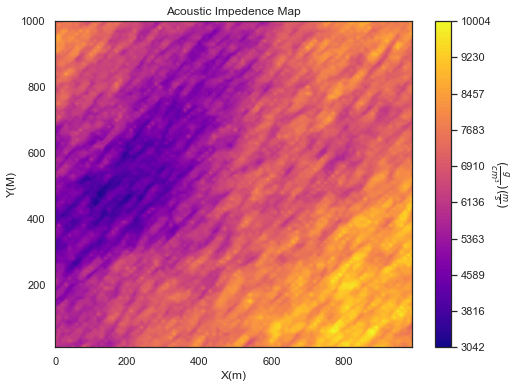

In [25]:
# plot of seismic data
pixelplt(AI_map, xmin, xmax, ymin, ymax, cell_size, vmin, vmax,
         "Acoustic Impedence Map", "X(m)", "Y(M)", r'$(\frac{g}{cm^3})(\frac{m}{s})$' , cmap, "AI_Map");

In [26]:
GSLIB.locpix

<function geostatspy.GSLIB.locpix(array, xmin, xmax, ymin, ymax, step, vmin, vmax, df, xcol, ycol, vcol, title, xlabel, ylabel, vlabel, cmap, fig_name)>

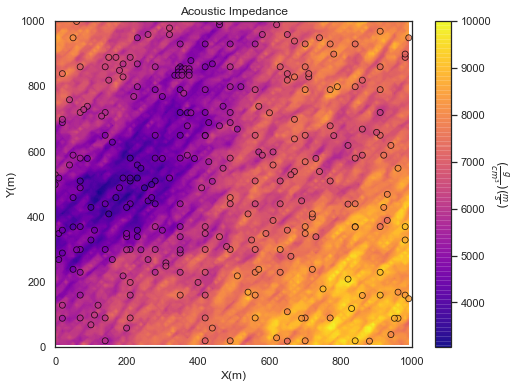

In [27]:
# plot of seismic data with sampling location
GSLIB.locpix(AI_map, xmin, xmax, ymin, ymax, gcsize, AImin, AImax, df,
             'X', 'Y', 'AI', 'Acoustic Impedance', 'X(m)', 'Y(m)',
             r'$(\frac{g}{cm^3})(\frac{m}{s})$', cmap, 'pixelplot_Acoustic_Impedance');

In [28]:
df['Facies Type'] = np.where(df['Facies']==0, 'Shale', 'Sand') # creation of dummy variable

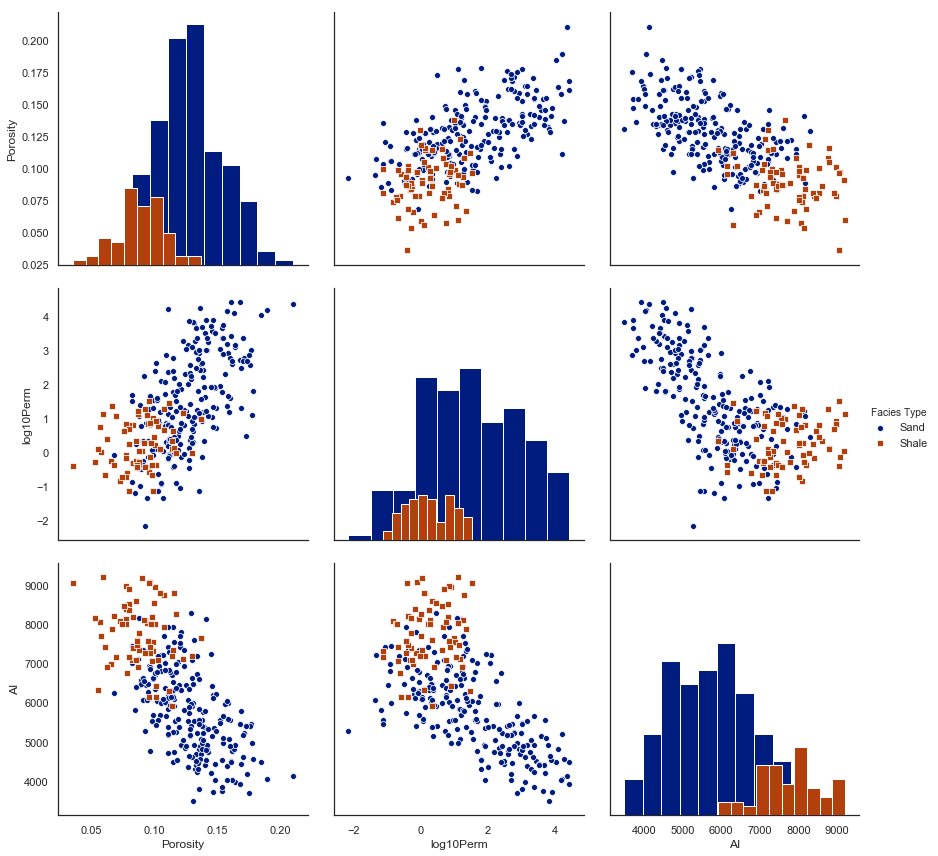

In [29]:
sns.pairplot(df, hue='Facies Type', height=4, vars=['Porosity', 'log10Perm', 'AI'], palette='dark', markers=['o', 's'],
            diag_kind='hist');

C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


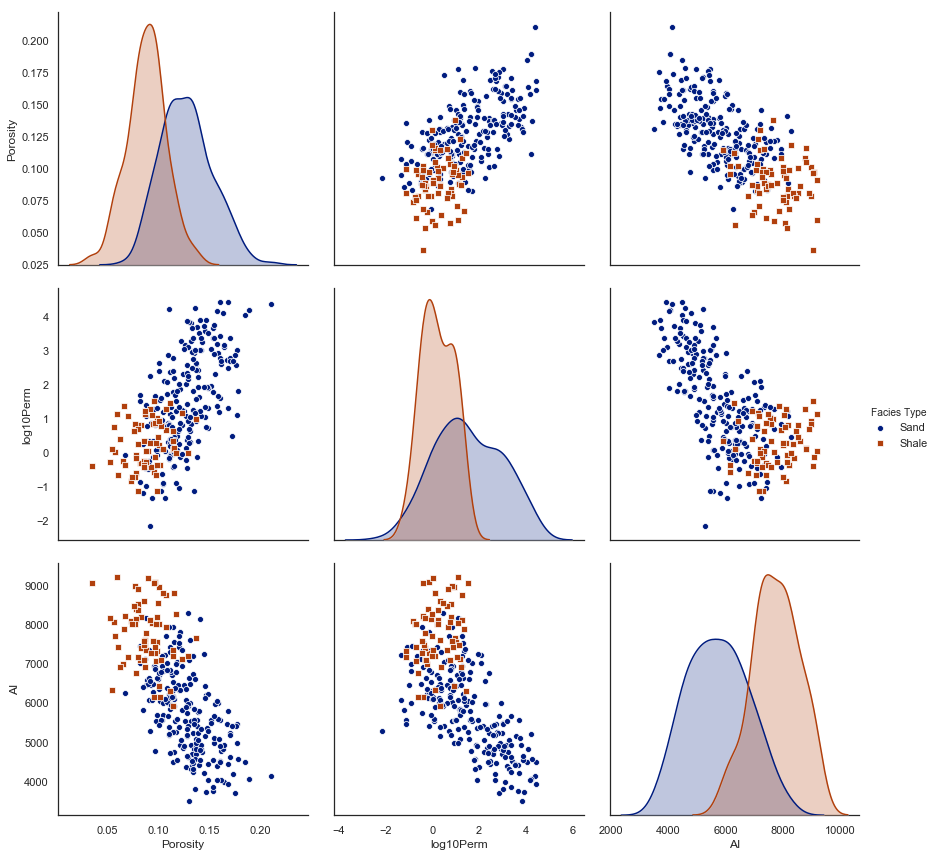

In [30]:
sns.pairplot(df, hue='Facies Type', height=4, vars=['Porosity', 'log10Perm', 'AI'], palette='dark', markers=['o', 's']);

Above, we see three scatterplots for the different numerical variables: AI, log10(permeability) and porosity.
The diagonal axes contain the univariate distribution of the data, classified by its facies type.

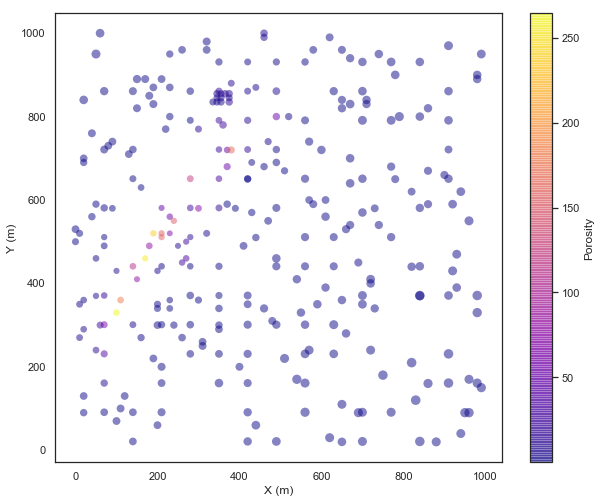

In [31]:
# This plot is not useful because of the large scale difference among porosity, permeability and AI.
# Extract the data
X, Y = df['X'], df['Y']
porosity, permeability = df['Porosity'], df['Perm']

a4_dims = (10, 8.27)
fig, ax = plt.subplots(figsize=a4_dims)

# Scatter the points, using size and color but no label
plt.scatter(X, Y, label=None, c=permeability/100, cmap='plasma',
           s=(df['AI'].values)/100, linewidth=0, alpha=0.5)
plt.axis(aspect='equal')
plt.xlabel('X (m)')
plt.ylabel('Y (m)')
plt.colorbar(label='Porosity');

Although it should not be included in the first report, the linear correlation between variables (Pearson's method) is below.

In [32]:
variab = df.iloc[:, 4:7]
variab.head()
variab.corr()

,Porosity,Perm,AI
Porosity,1.000000,0.392560,-0.698005
Perm,0.392560,1.000000,-0.391876
AI,-0.698005,-0.391876,1.000000


In [33]:
df_sh = df[df['Facies Type'] == 'Shale'] # Creation of df containing only shale parameters
df_sd = df[df['Facies Type'] == 'Sand'] # Creation of df containing only sand parameters

In [34]:
df_sh.head()

,Sample_n,X,Y,Facies,Porosity,Perm,AI,log10Perm,Facies Type
50,82,420.0,90.0,0.0,0.065979,0.574035,6988.275096,-0.241062,Shale
51,83,420.0,20.0,0.0,0.082750,0.483293,7092.007633,-0.315790,Shale
58,97,490.0,20.0,0.0,0.058288,1.013465,7689.998359,0.005809,Shale
61,102,560.0,650.0,0.0,0.078260,0.242697,6762.697531,-0.614935,Shale
65,108,560.0,230.0,0.0,0.137356,9.531058,7658.708167,0.979141,Shale


C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\figure.py:98: Matplotlib

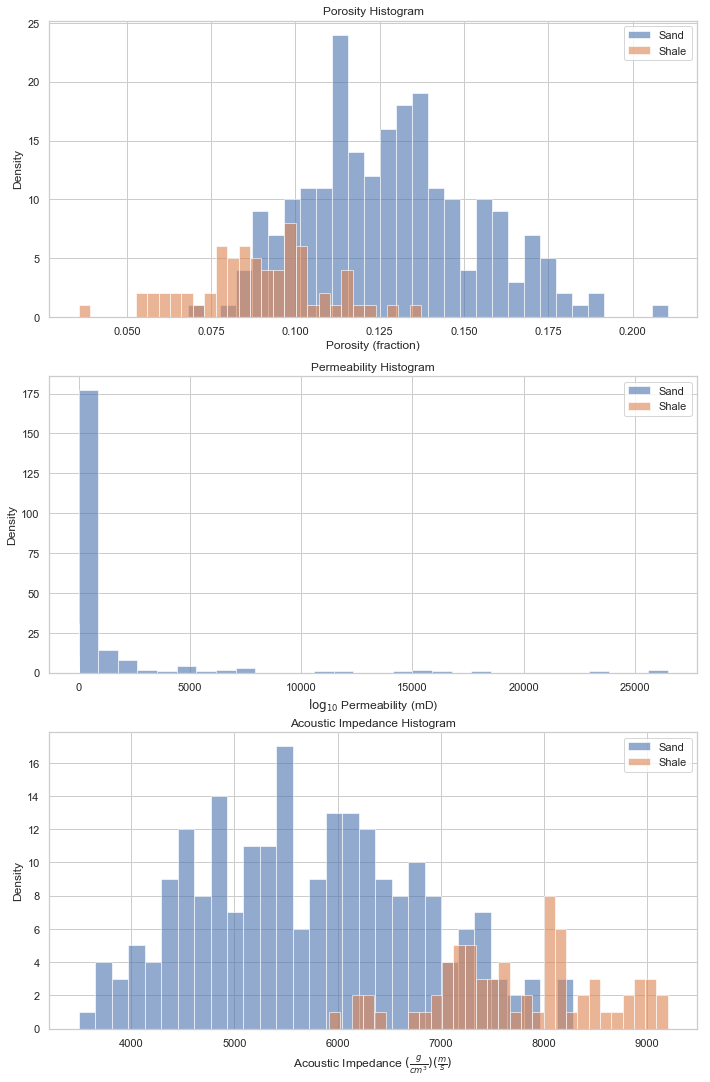

In [50]:
# Plotting of histogram considering facies

fig = plt.figure()
ax1 = fig.add_subplot(311)
ax2 = fig.add_subplot(312)
ax3 = fig.add_subplot(313)

plt.subplot(311)
ax1.hist(df_sd['Porosity'].values, label='Sand', bins=30, alpha=0.6,)
ax1.hist(df_sh['Porosity'].values, label='Shale', bins=30, alpha=0.6)
ax1.set(xlabel='Porosity (fraction)', ylabel='Density', title='Porosity Histogram')
ax1.legend();

plt.subplot(312)
ax2.hist(df_sd['Perm'].values, label='Sand', bins=30, alpha=0.6,)
ax2.hist(df_sh['Perm'].values, label='Shale', bins=30, alpha=0.6)
ax2.set(xlabel='$\log_{10}$ Permeability (mD)', ylabel='Density', title='Permeability Histogram')
ax2.legend();

plt.subplot(313)
ax3.hist(df_sd['AI'].values, label='Sand', bins=30, alpha=0.6)
ax3.hist(df_sh['AI'].values, label='Shale', bins=30, alpha=0.6)
ax3.set(xlabel=r'Acoustic Impedance $(\frac{g}{cm^3})(\frac{m}{s})$', ylabel='Density', title='Acoustic Impedance Histogram')
ax3.legend();

fig.subplots_adjust(left=0.0, bottom=0.0, right=1.5, top=3.5, wspace=0.1, hspace=0.2);

We use the transformation of permeability for ease of visualization. If we had not, the histogram would not convey a description of the facies. Again, the permeability values has a large positive skewness of 4.95. See below.

In [36]:
df['Perm'].skew()

4.945018248402226

https://machinelearningmastery.com/quick-and-dirty-data-analysis-with-pandas/

### Outliers

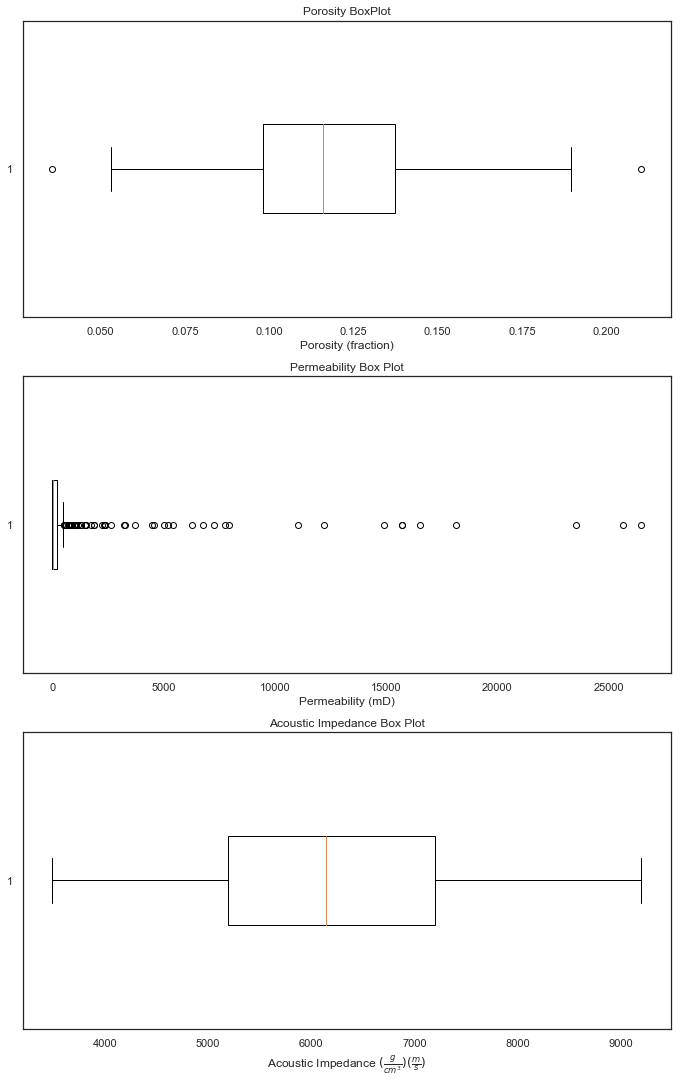

In [37]:
fig, axes = plt.subplots(3, 1)
axes[0].boxplot(df['Porosity'].values, widths=0.3, vert=False)
axes[0].set(xlabel='Porosity (fraction)', title='Porosity BoxPlot')

axes[1].boxplot(df['Perm'].values, widths=0.3, vert=False)
axes[1].set(xlabel='Permeability (mD)', title='Permeability Box Plot')

axes[2].boxplot(df['AI'].values, widths=0.3, vert=False)
axes[2].set(xlabel=r'Acoustic Impedance $(\frac{g}{cm^3})(\frac{m}{s})$', title='Acoustic Impedance Box Plot')

fig.subplots_adjust(left=0.0, bottom=0.0, right=1.5, top=3.5, wspace=0.1, hspace=0.2);

In [38]:
# Finding outliers: lower and upper fence for each variable
outliers = {}
for i in ['Porosity', 'Perm', 'AI']:
    Q1 = df[i].quantile(0.25)
    Q3 = df[i].quantile(0.75)
    IQR = Q3 - Q1
    lower_f = Q1 - 1.5 * IQR
    upper_f = Q3 + 1.5 * IQR
    outliers[i] = [lower_f, upper_f]
print(outliers)

{'Porosity': [0.039394137303859274, 0.196067547355384], 'Perm': [-298.5801714702821, 501.1016189785891], 'AI': [2196.1504017322945, 10200.957958982985]}


In [39]:
outliers = pd.DataFrame(outliers, index=['lower fence', 'upper fence'])
outliers[outliers < 0] = 0 # correcting those lower fences that have negative values (non-physical)
outliers.head()

,Porosity,Perm,AI
lower fence,0.039394,0.000000,2196.150402
upper fence,0.196068,501.101619,10200.957959


In [40]:
ind1 = df.loc[(df['Porosity'] < outliers.iloc[0, 0]) | (df['Porosity'] > outliers.iloc[1, 0])]
ind2 = df.loc[(df['Perm'] < outliers.iloc[0, 1]) | (df['Perm'] > outliers.iloc[1, 1])]
ind3 = df.loc[(df['AI'] < outliers.iloc[0, 2]) | (df['AI'] > outliers.iloc[1, 2])]
tout = pd.concat([ind1, ind2, ind3])
tout['Type'] = 'Outlier'
tout.info() # DataFrame with all outliers; total outliers
df['Type'] = 'Normal' # Create a dummy column
df.loc[tout.index, 'Type'] = 'Outlier'
df['Outlier'] = 0
df['Outlier'][df['Type'] == 'Outlier'] = 1

<class 'pandas.core.frame.DataFrame'>
Int64Index: 57 entries, 88 to 291
Data columns (total 10 columns):
Sample_n       57 non-null int64
X              57 non-null float64
Y              57 non-null float64
Facies         57 non-null float64
Porosity       57 non-null float64
Perm           57 non-null float64
AI             57 non-null float64
log10Perm      57 non-null float64
Facies Type    57 non-null object
Type           57 non-null object
dtypes: float64(7), int64(1), object(2)
memory usage: 4.9+ KB


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.


In [41]:
sd_ot = df[df['Facies Type'] == 'Sand']
sh_ot = df[df['Facies Type'] == 'Shale']

In [42]:
sd_ot.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 222 entries, 0 to 291
Data columns (total 11 columns):
Sample_n       222 non-null int64
X              222 non-null float64
Y              222 non-null float64
Facies         222 non-null float64
Porosity       222 non-null float64
Perm           222 non-null float64
AI             222 non-null float64
log10Perm      222 non-null float64
Facies Type    222 non-null object
Type           222 non-null object
Outlier        222 non-null int64
dtypes: float64(7), int64(2), object(2)
memory usage: 20.8+ KB


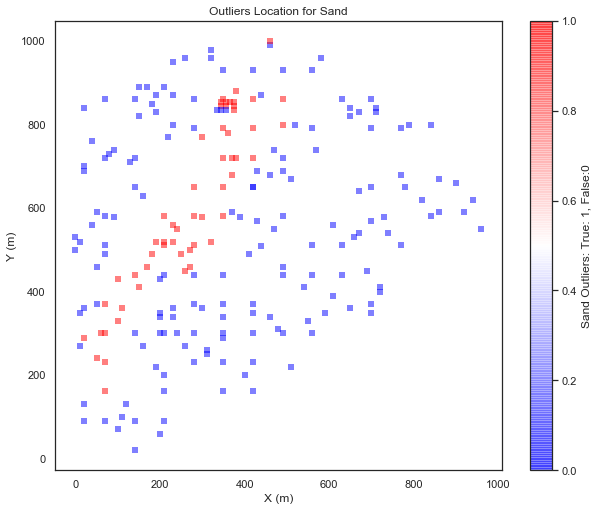

In [43]:
# Extract the data outliers of sand
X, Y = sd_ot['X'], sd_ot['Y']
faciesnp= sd_ot['Outlier']

a4_dims = (10, 8.27)
fig, ax = plt.subplots(figsize=a4_dims)

# Scatter the points, using size and color but no label
plt.scatter(X, Y, c=faciesnp, cmap='bwr', linewidth=0, alpha=0.5, marker='s')
plt.axis(aspect='equal')
plt.xlabel('X (m)')
plt.ylabel('Y (m)')
plt.title('Outliers Location for Sand')
plt.colorbar(label='Sand Outliers: True: 1, False:0');

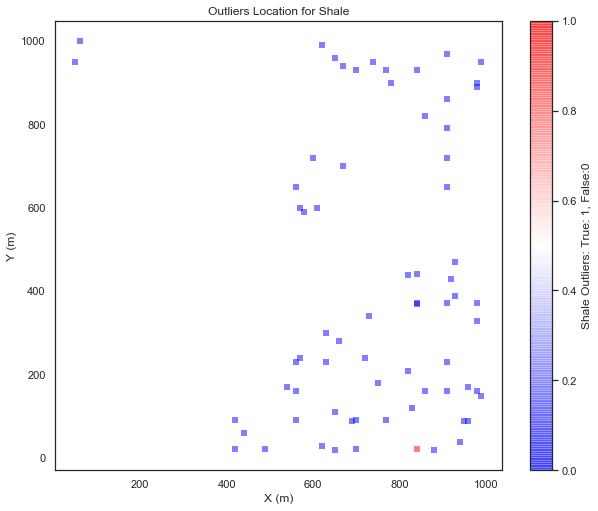

In [44]:
# Extract the data outliers of shale
X, Y = sh_ot['X'], sh_ot['Y']
faciesnp= sh_ot['Outlier']

a4_dims = (10, 8.27)
fig, ax = plt.subplots(figsize=a4_dims)

# Scatter the points, using size and color but no label
plt.scatter(X, Y, c=faciesnp, cmap='bwr', linewidth=0, alpha=0.5, marker='s')
plt.axis(aspect='equal')
plt.xlabel('X (m)')
plt.ylabel('Y (m)')
plt.title('Outliers Location for Shale')
plt.colorbar(label='Shale Outliers: True: 1, False:0');

In [45]:
df.head()

,Sample_n,X,Y,Facies,Porosity,Perm,AI,log10Perm,Facies Type,Type,Outlier
0,1,70.0,860.0,1.0,0.118640,3.117596,7035.590426,0.493820,Sand,Normal,0
1,3,70.0,720.0,1.0,0.120775,1.755401,6327.155846,0.244376,Sand,Normal,0
2,5,70.0,580.0,1.0,0.152136,90.385506,5547.976415,1.956099,Sand,Normal,0
3,6,70.0,510.0,1.0,0.148497,81.199756,4025.534147,1.909555,Sand,Normal,0
4,8,70.0,370.0,1.0,0.158123,1497.094898,4385.428975,3.175249,Sand,Outlier,1


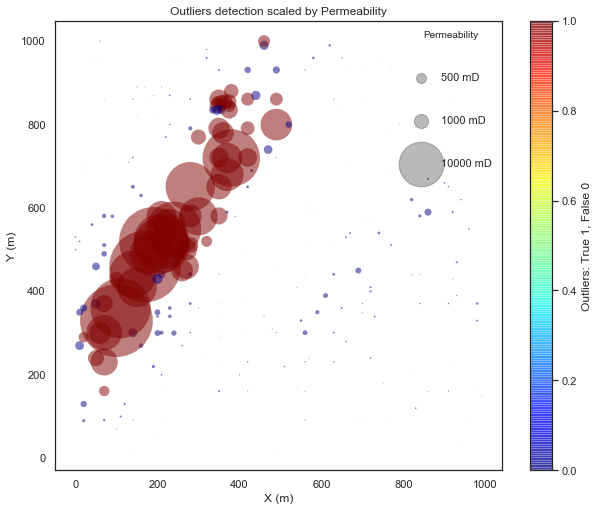

In [46]:
# Extract the data
X, Y = df['X'], df['Y']
outli, permeability, AI = df['Outlier'], df['Perm'], df['AI']

a4_dims = (10, 8.27)
fig, ax = plt.subplots(figsize=a4_dims)

# Scatter the points, using size and color but no label
plt.scatter(X, Y, label=None, c=outli, cmap='jet',
           s=permeability/5, linewidth=0, alpha=0.5) # We divided the permeability by 5, for visualization processes.
plt.axis(aspect='equal')
plt.xlabel('X (m)')
plt.ylabel('Y (m)')
plt.colorbar(label='Outliers: True 1, False 0')

# Here we create a legend
# We'll plot empty lists with the desired size and label. We divided the permeability by 5, for visualization processes.
for k in [500, 1000, 10000]:
    plt.scatter([], [], c='k', alpha=0.3, s=k/5,
               label=str(k) + ' mD')
    plt.legend(scatterpoints=1, frameon=False, labelspacing=3, title='Permeability')

    
plt.title('Outliers detection scaled by Permeability');

In [47]:
df.head()

,Sample_n,X,Y,Facies,Porosity,Perm,AI,log10Perm,Facies Type,Type,Outlier
0,1,70.0,860.0,1.0,0.118640,3.117596,7035.590426,0.493820,Sand,Normal,0
1,3,70.0,720.0,1.0,0.120775,1.755401,6327.155846,0.244376,Sand,Normal,0
2,5,70.0,580.0,1.0,0.152136,90.385506,5547.976415,1.956099,Sand,Normal,0
3,6,70.0,510.0,1.0,0.148497,81.199756,4025.534147,1.909555,Sand,Normal,0
4,8,70.0,370.0,1.0,0.158123,1497.094898,4385.428975,3.175249,Sand,Outlier,1


C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


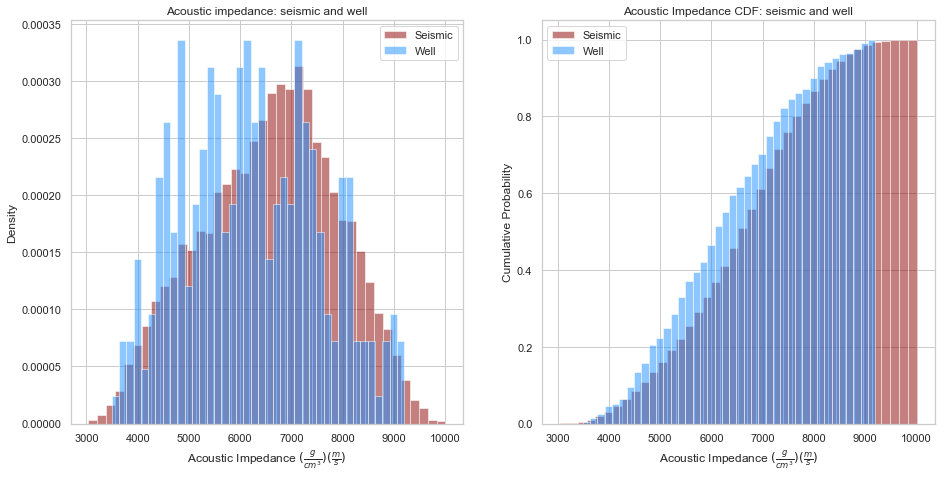

In [48]:
# Plotting of histogram of AI: seismic vs wells
sns.set_style('whitegrid')

fig = plt.figure()
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

plt.subplot(121)
ax1.hist(AI_map.flatten(), label='Seismic', bins=40, alpha=0.5, density=True, color='darkred')
ax1.hist(df['AI'].values, label='Well', bins=40, alpha=0.5, density=True, color='dodgerblue')
ax1.plot()
ax1.set(xlabel=r'Acoustic Impedance $(\frac{g}{cm^3})(\frac{m}{s})$', ylabel='Density',
        title='Acoustic impedance: seismic and well')
ax1.legend();

plt.subplot(122)
ax2.hist(AI_map.flatten(), label='Seismic', bins=40, alpha=0.5, cumulative=True, density=True,
         color='darkred')
ax2.hist(df['AI'].values, label='Well', bins=40, alpha=0.5, cumulative=True, density=True,
         color='dodgerblue')
ax2.set(xlabel=r'Acoustic Impedance $(\frac{g}{cm^3})(\frac{m}{s})$', ylabel='Cumulative Probability',
        title='Acoustic Impedance CDF: seismic and well')
ax2.legend();

fig.subplots_adjust(left=0.0, bottom=1, right=2, top=2.4, wspace=0.2, hspace=0.2);

C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


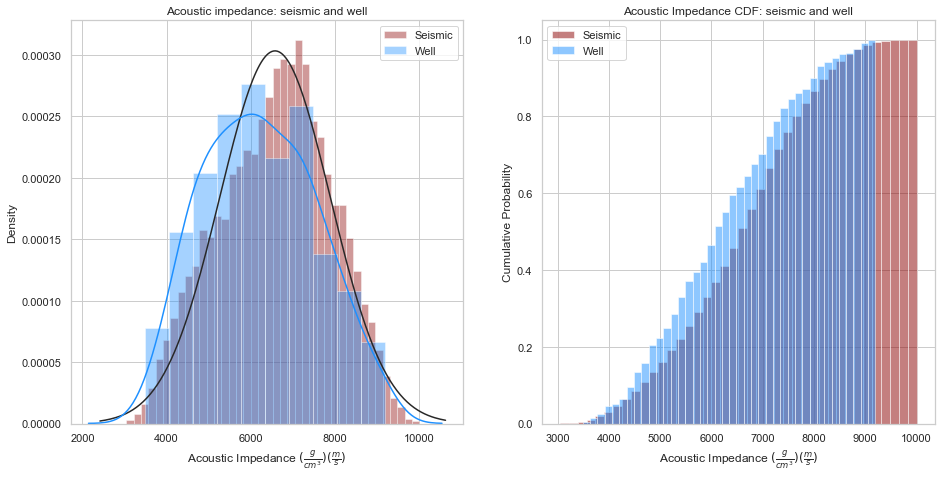

In [49]:
# Plotting of histogram of AI: seismic vs wells
sns.set_style('whitegrid')
from scipy.stats import norm

fig = plt.figure()
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

plt.subplot(121)
sns.distplot(AI_map.flatten(), kde=False, color='darkred', fit=norm, label='Seismic')
sns.distplot(df['AI'], kde=True, color='dodgerblue', label='Well')
ax1.set(xlabel=r'Acoustic Impedance $(\frac{g}{cm^3})(\frac{m}{s})$', ylabel='Density',
        title='Acoustic impedance: seismic and well')
ax1.legend();

plt.subplot(122)
ax2.hist(AI_map.flatten(), label='Seismic', bins=40, alpha=0.5, cumulative=True, density=True,
         color='darkred')
ax2.hist(df['AI'].values, label='Well', bins=40, alpha=0.5, cumulative=True, density=True,
         color='dodgerblue')
ax2.set(xlabel=r'Acoustic Impedance $(\frac{g}{cm^3})(\frac{m}{s})$', ylabel='Cumulative Probability',
        title='Acoustic Impedance CDF: seismic and well')
ax2.legend();

fig.subplots_adjust(left=0.0, bottom=1, right=2, top=2.4, wspace=0.2, hspace=0.2);

* On the left: histogram of the acoustic impedance for both seismic (1000 data points) and well (292 data points) data. We have fitted a normal distribution to the seismic histogram for comparison. The seismic data set does not look Gaussian distributed. On the other hand, the AI data from the wells have a gaussian kernel density estimate, to infere its PDF.
    
* Right: cumulative probability of AI for sample and population.